# 삼중항 손실(triplet loss)이 있는 샴 네트워크(Siamese Network)를 사용한 이미지 유사도 추정

Siamese Networks는 중복 감지, anomaly detection, 얼굴 인식과 같은 다양한 사용 사례에 적용될 수 있습니다.

이 예에서는 3개의 동일한 subnetwork가 있는 샴 네트워크를 사용합니다. 모델에 3개의 이미지를 제공합니다. 여기서
그 중 두 개는 비슷할 것이고(_anchor_ 및 _positive_ sample), 세 번째는 관련이 없을 것입니다(_negative_ sample).
우리의 목표는 모델이 이미지 간의 유사성을 추정하는 방법을 배우도록 하는  것입니다.

네트워크가 학습하기 위해 삼중항 손실 함수(triple loss function)를 사용합니다.

`L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)`

이 예시는 [Totally Looks Like dataset](https://sites.google.com/view/totally-looks-like-dataset)를 사용합니다.
[Rosenfeld et al., 2018](https://arxiv.org/pdf/1803.01485v3.pdf).  

- 데이터 세트에는 6016개의 이미지 쌍이 포함되어 있습니다.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os
import random
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet
from tensorflow.keras.utils import plot_model
import time

target_shape = (200, 200)

## dataset load

*Totally Looking Like* 데이터세트를 로드하고 압축을 풉니다.

데이터세트는 두 개의 개별 파일로 구성됩니다.

* `left.zip`에는 anchor로 사용할 이미지가 포함되어 있습니다.
* `right.zip`에는 positive 샘플(앵커처럼 보이는 이미지)로 사용할 이미지가 포함되어 있습니다.

In [2]:
cache_dir = Path("/content/")
anchor_images_path = cache_dir / "left"
positive_images_path = cache_dir / "right"

cache_dir, anchor_images_path, positive_images_path

(PosixPath('/content'),
 PosixPath('/content/left'),
 PosixPath('/content/right'))

In [3]:
#OYJ gdrive에서 file download 및 압축 해제
!gdown 1RxrOFgTLcv_f0HLwJeGOq4kJEHVgC4m7
!gdown 1--Us3zRNRGYWNpWJBlIkXEjiNmo39_Ue

!unzip -oq left.zip -d $cache_dir
!unzip -oq right.zip -d $cache_dir

Downloading...
From: https://drive.google.com/uc?id=1RxrOFgTLcv_f0HLwJeGOq4kJEHVgC4m7
To: /content/right.zip
100% 104M/104M [00:00<00:00, 243MB/s]
Downloading...
From: https://drive.google.com/uc?id=1--Us3zRNRGYWNpWJBlIkXEjiNmo39_Ue
To: /content/left.zip
100% 104M/104M [00:00<00:00, 122MB/s] 


In [4]:
# !gdown 1jvkbTr_giSP3Ru8OwGNCg6B4PvVbcO34
# !gdown 1EzBZUb_mh_Dp_FKD0P4XiYYSd0QBH5zW

## 데이터 준비

우리는 `tf.data` 파이프라인을 사용하여 데이터를 로드하고 Siamese 네트워크를 훈련하는 데 필요한 삼중항을 생성할 것입니다.

anchor, positive, 및 negative 파일 이름이 소스로 포함된 압축 목록을 사용하여 파이프라인을 설정합니다. 파이프라인은 해당 이미지를 로드하고 사전 처리합니다.

preprocess_image 함수는 주어진 파일명으로 이미지를 불러오고, 이 이미지를 TensorFlow를 사용해 전처리한 후 목표 크기로 조정합니다.

preprocess_triplets 함수는 'anchor', 'positive', 'negative' 세 개의 이미지에 대해 preprocess_image 함수를 호출하여 각각의 이미지를 불러오고 전처리합니다. 이 함수는 보통 triplet loss를 이용한 학습에서 사용되며, 'anchor'는 기준이 되는 이미지, 'positive'는 기준 이미지와 같은 클래스에 속하는 이미지, 'negative'는 기준 이미지와 다른 클래스에 속하는 이미지를 의미합니다.

In [5]:
def preprocess_image(filename):
    """
    주어진 파일을 JPEG 이미지로 불러오고, 전처리를 거친 후에 목표 크기로 조정합니다.
    """
    image_string = tf.io.read_file(filename)   # 파일의 내용을 읽습니다.
    image = tf.image.decode_jpeg(image_string, channels=3)  # JPEG 인코딩된 이미지를 uint8 텐서로 디코딩합니다.
    image = tf.image.convert_image_dtype(image, tf.float32) # 필요한 경우 이미지의 값들을 스케일링하면서 이미지를 dtype으로 변환합니다.
    image = tf.image.resize(image, target_shape) # 지정된 방법을 사용하여 이미지 크기를 조정합니다.
    return image

def preprocess_triplets(anchor, positive, negative):
    """
    세 개의 이미지에 해당하는 파일 이름이 주어지면, 이미지를 불러온 후 전처리합니다.
    """
    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

anchor,  positive 및 negative 이미지 파일 이름이 소스로 포함된 압축 목록을 사용하여 데이터 파이프라인을 설정해 보겠습니다. 파이프라인의 출력에는 모든 이미지가 load 되고 사전 처리된 동일한 triplet이 포함됩니다.

앵커 이미지와 포지티브 이미지가 모두 정렬된 순서로 load 되었는지 확인하여 함께 일치시킬 수 있도록 해야 합니다.

In [6]:
os.listdir(anchor_images_path)[:5], os.listdir(positive_images_path)[:5]

(['02533.jpg', '04723.jpg', '05021.jpg', '03195.jpg', '02774.jpg'],
 ['02533.jpg', '04723.jpg', '05021.jpg', '03195.jpg', '02774.jpg'])

In [7]:
# 'anchor_images_path' 디렉토리에 있는 모든 파일의 경로를 가져와서 정렬합니다.
# 각 경로는 문자열로 변환되어 'anchor_images' 리스트에 저장됩니다.
anchor_images = sorted(
    [str(anchor_images_path / f) for f in os.listdir(anchor_images_path)]
)

# 'positive_images_path' 디렉토리에 있는 모든 파일의 경로를 가져와서 정렬합니다.
# 각 경로는 문자열로 변환되어 'positive_images' 리스트에 저장됩니다.
positive_images = sorted(
    [str(positive_images_path / f) for f in os.listdir(positive_images_path)]
)

# 'anchor_images'와 'positive_images' 리스트의 길이를 출력합니다.
# 이는 각 디렉토리에 있는 이미지 파일의 수를 나타냅니다.
print(len(anchor_images), len(positive_images))

# 'anchor_images'와 'positive_images' 리스트의 처음 5개 요소를 출력합니다.
# 이는 각 디렉토리에서 사전 순으로 가장 먼저 오는 이미지 파일 5개의 경로를 보여줍니다.
anchor_images[:5], positive_images[:5]


6016 6016


(['/content/left/00000.jpg',
  '/content/left/00001.jpg',
  '/content/left/00002.jpg',
  '/content/left/00003.jpg',
  '/content/left/00004.jpg'],
 ['/content/right/00000.jpg',
  '/content/right/00001.jpg',
  '/content/right/00002.jpg',
  '/content/right/00003.jpg',
  '/content/right/00004.jpg'])

anchor image와 positive image가 정렬되어 있는지 확인

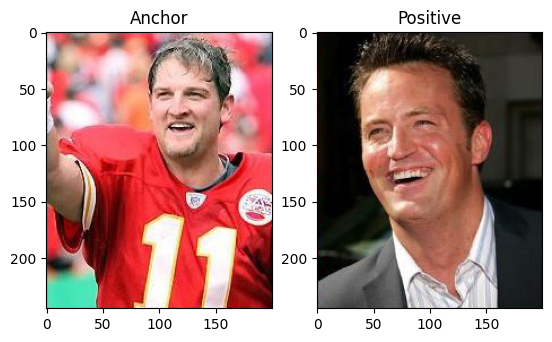

In [8]:
img1 = Image.open(anchor_images[0])
img2 = Image.open(positive_images[0])
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Anchor')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Positive')
plt.show()

Anchor / Positive Data generator 생성

In [9]:
anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)

for img1, img2 in zip(anchor_dataset.take(5), positive_dataset.take(5)):
    print(img1, img2)

tf.Tensor(b'/content/left/00000.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00000.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00001.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00001.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00002.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00002.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00003.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00003.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00004.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/00004.jpg', shape=(), dtype=string)


negative 이미지 목록을 생성하기 위해 사용 가능한 이미지 목록을 무작위로 만들고 함께 연결합니다.

In [10]:
# anchor_images 목록과 positive_images 목록을 shuffle 후 add 하여 negative_images  목록 생성
rng1 = np.random.RandomState(seed=42)
rng1.shuffle(anchor_images)
rng1.shuffle(positive_images)

negative_images = anchor_images + positive_images
print(len(negative_images))

# negative_images 목록 shuffle
rng2 = np.random.RandomState(seed=32)
rng2.shuffle(negative_images)

negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)
negative_dataset = negative_dataset.shuffle(buffer_size=4096)

for img1, img2 in zip(anchor_dataset.take(5), negative_dataset .take(5)):
    print(img1, img2)

12032
tf.Tensor(b'/content/left/00000.jpg', shape=(), dtype=string) tf.Tensor(b'/content/left/01006.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00001.jpg', shape=(), dtype=string) tf.Tensor(b'/content/left/05449.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00002.jpg', shape=(), dtype=string) tf.Tensor(b'/content/right/02815.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00003.jpg', shape=(), dtype=string) tf.Tensor(b'/content/left/03517.jpg', shape=(), dtype=string)
tf.Tensor(b'/content/left/00004.jpg', shape=(), dtype=string) tf.Tensor(b'/content/left/04479.jpg', shape=(), dtype=string)


Anchor와 Negative Image 가 불일치 하는지 확인

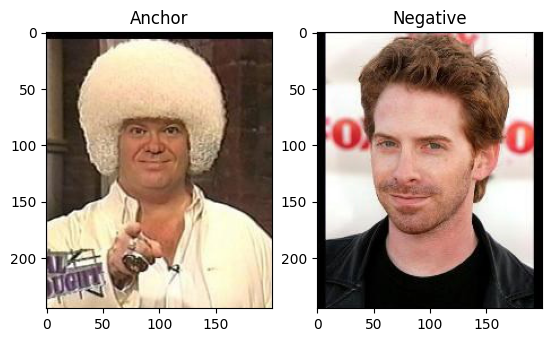

In [11]:
img1 = Image.open(anchor_images[0])
img2 = Image.open(negative_images[0])
plt.subplot(1, 2, 1)
plt.imshow(img1)
plt.title('Anchor')
plt.subplot(1, 2, 2)
plt.imshow(img2)
plt.title('Negative')
plt.show()

In [12]:
len(anchor_dataset), len(positive_dataset), len(negative_dataset)

(6016, 6016, 12032)

Triple Data의 generator 생성

In [13]:
# 'anchor_dataset', 'positive_dataset', 'negative_dataset'을 결합하여 새로운 데이터셋을 만듭니다.
# 각 데이터셋에서 같은 위치에 있는 element들이 하나의 데이터 포인트를 구성합니다.
dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))

# 데이터셋을 섞습니다. 'buffer_size=1024'은 한 번에 섞을 element의 수를 설정합니다.
dataset = dataset.shuffle(buffer_size=1024)

# 'preprocess_triplets' 함수를 사용하여 데이터셋의 각 element를 전처리합니다.
# 이 함수는 각 이미지 파일의 이름을 이미지 데이터로 변환하고, 해당 이미지를 필요한 크기로 조정합니다.
dataset = dataset.map(preprocess_triplets)

# 'anchor_dataset'의 길이를 계산하여 이미지의 총 개수를 구합니다.
image_count = len(anchor_dataset)

# 데이터셋을 학습 세트와 검증 세트로 분할합니다.
# 학습 세트는 전체 이미지의 80%를, 검증 세트는 나머지 20%를 포함합니다.
train_dataset = dataset.take(round(image_count * 0.8))
val_dataset = dataset.skip(round(image_count * 0.8))

# 'drop_remainder=False'를 설정하여 마지막 배치의 크기가 batch_size보다 작아도 남기도록 합니다.
# 'prefetch(8)'를 사용하여 학습 중에 다음 배치를 미리 준비하도록 합니다.
train_dataset = train_dataset.batch(32, drop_remainder=False).prefetch(8)
val_dataset = val_dataset.batch(32, drop_remainder=False).prefetch(8)

train_dataset, val_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 200, 200, 3), dtype=tf.float32, name=None))>)

Triplelet의 몇 가지 예를 살펴봅니다. 세 번째 이미지는 항상 다른 반면 처음 두 이미지는 유사한 것을 확인합니다.

In [14]:
def visualize(anchor, positive, negative):
    """
    제공된 배치에서 몇 개의 트리플렛 이미지를 시각화하는 함수입니다.

    매개변수:
    anchor: 시각화할 'Anchor' 이미지 배치
    positive: 시각화할 'Positive' 이미지 배치
    negative: 시각화할 'Negative' 이미지 배치
    """

    def show(ax, image, title):
        """
        지정된 축에 이미지와 제목을 표시하는 도우미 함수입니다.

        매개변수:
        ax: 이미지를 표시할 축
        image: 표시할 이미지
        title: 이미지의 제목
        """
        ax.imshow(image)  # 이미지를 축에 표시
        ax.set_title(title)  # 제목을 설정
        ax.get_xaxis().set_visible(False)  # x축을 숨김
        ax.get_yaxis().set_visible(False)  # y축을 숨김

    fig = plt.figure(figsize=(9, 9))  # 9x9 크기의 새로운 figure를 생성

    # 3x3 서브플롯을 생성. 각 행은 트리플렛 하나(Anchor, Positive, Negative)를 나타냄.
    axs = fig.subplots(3, 3)
    for i in range(3):  # 각 트리플렛에 대해
        show(axs[i, 0], anchor[i], 'anchor')  # Anchor 이미지를 표시
        show(axs[i, 1], positive[i], 'positive')  # Positive 이미지를 표시
        show(axs[i, 2], negative[i], 'negative')  # Negative 이미지를 표시


as_numpy_iterator 메소드는 Dataset의 모든 요소를 numpy로 변환하는 iterator를 리턴

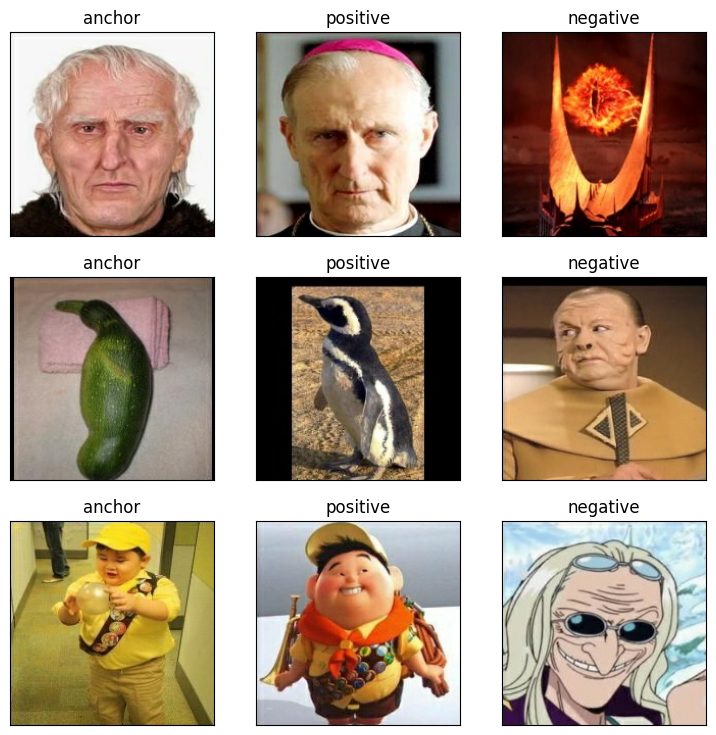

In [15]:
visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

## 임베딩 생성기 모델 설정

Siamese 네트워크는 삼중항의 각 이미지에 대한 임베딩을 생성합니다. 이를 위해 ImageNet에서 사전 훈련된 ResNet50 모델을 사용하고 몇 개의 'Dense' 레이어를 연결하여 이러한 임베딩을 분리하는 방법을 배울 것입니다.

모델의 모든 레이어의 가중치를 `conv5_block1_out` 레이어까지 고정합니다.
이는 모델이 이미 학습한 가중치에 영향을 미치지 않도록 하는 데 중요합니다.
우리는 훈련 중에 가중치를 미세 조정할 수 있도록 맨 아래 몇 개의 레이어를 훈련 가능한 상태로 둘 것입니다.

In [16]:
target_shape + (3,)

(200, 200, 3)

In [17]:
# ResNet50 모델을 기본 합성곱 네트워크로 사용합니다.
# weights="imagenet"은 ImageNet 데이터셋으로 사전 학습된 가중치를 사용하도록 설정합니다.
# input_shape=target_shape + (3,)은 입력 이미지의 크기를 설정합니다. target_shape는 이미지의 높이와 너비를, (3,)은 색상 채널의 수를 나타냅니다.
# include_top=False는 최상위 전결합층(즉, 분류층)을 포함하지 않도록 설정합니다. 이는 특성 추출을 위해 기본 모델을 사용하고자 할 때 유용합니다.
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

base_cnn.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 206, 206, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 100, 100, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

ResNet50 모델의 출력에 추가적인 완전 연결 층(Dense layers)과 배치 정규화 층(BatchNormalization layers)을 연결하고, 이를 통해 새로운 임베딩 모델을 만듭니다. 또한, "conv5_block1_out" 층부터 마지막 층까지의 ResNet50 모델의 가중치를 학습 가능하게 하여, 이 부분의 가중치가 학습 과정에서 업데이트되도록 합니다. 이렇게 하면, 사전 학습된 ResNet50 모델의 일부 가중치를 우리의 데이터셋에 맞게 미세 조정(fine-tuning)할 수 있습니다.

In [18]:
# ResNet50의 출력을 Flatten 층에 전달하여 1차원 벡터로 만듭니다.
flatten = layers.Flatten()(base_cnn.output)

# 첫 번째 완전 연결(Dense) 층을 추가하고 ReLU 활성화 함수를 사용합니다.
x = layers.Dense(512, activation="relu")(flatten)

# 배치 정규화 층을 추가하여 이전 층의 출력을 정규화합니다.
x = layers.BatchNormalization()(x)

# 두 번째 완전 연결(Dense) 층을 추가하고 ReLU 활성화 함수를 사용합니다.
x = layers.Dense(256, activation="relu")(x)

# 배치 정규화 층을 추가하여 이전 층의 출력을 정규화합니다.
x = layers.BatchNormalization()(x)

# 마지막 완전 연결(Dense) 층을 추가하여 최종 임베딩 벡터를 생성합니다.
# 이 층에서는 활성화 함수를 사용하지 않습니다.
output = layers.Dense(256)(x)

# ResNet50 모델의 입력을 받아 우리가 추가한 층들을 거쳐 최종 임베딩 벡터를 출력하는 새로운 모델을 만듭니다.
embedding = Model(base_cnn.input, output, name="Embedding")

# ResNet50의 일부 층을 동결하거나 동결을 해제합니다.
# 여기서는 "conv5_block1_out" 층까지는 동결 상태로 유지하고,
# 그 이후의 층들은 동결을 해제하여 학습 중에 가중치가 업데이트되도록 합니다.
trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True  # 이 블록 이후로는 layer.trainable을 True로 변경
    layer.trainable = trainable

## 샴 네트워크 모델 설정

샴 네트워크는 각각의 삼중항 이미지를 입력으로 받아 임베딩을 생성하고 앵커와 포지티브 임베딩 사이의 거리와 앵커와 네거티브 임베딩 사이의 거리를 출력합니다.

거리를 계산하기 위해 두 값을 튜플로 반환하는 사용자 지정 레이어 'DistanceLayer'를 사용할 수 있습니다.

In [19]:
# DistanceLayer는 사용자 정의 층으로, 앵커 임베딩과 포지티브 임베딩, 앵커 임베딩과 네거티브 임베딩 사이의 거리를 계산합니다.
class DistanceLayer(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        # ap_distance는 앵커와 포지티브 사이의 거리를, an_distance는 앵커와 네거티브 사이의 거리를 계산합니다.
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
        return (ap_distance, an_distance)

# 앵커, 포지티브, 네거티브 각각에 대한 입력을 정의합니다.
anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

# 입력 이미지를 임베딩 모델을 거쳐 각각의 임베딩 벡터를 생성합니다.
# 그 후, 이 임베딩 벡터들을 DistanceLayer에 전달하여 각 쌍 사이의 거리를 계산합니다.
distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

# 앵커, 포지티브, 네거티브 입력을 받아 거리를 출력하는 샴 네트워크를 정의합니다.
siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input],
    outputs=distances
)

In [20]:
siamese_network.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 anchor (InputLayer)            [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 positive (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                                
                                                                                                  
 negative (InputLayer)          [(None, 200, 200, 3  0           []                               
                                )]                                                            

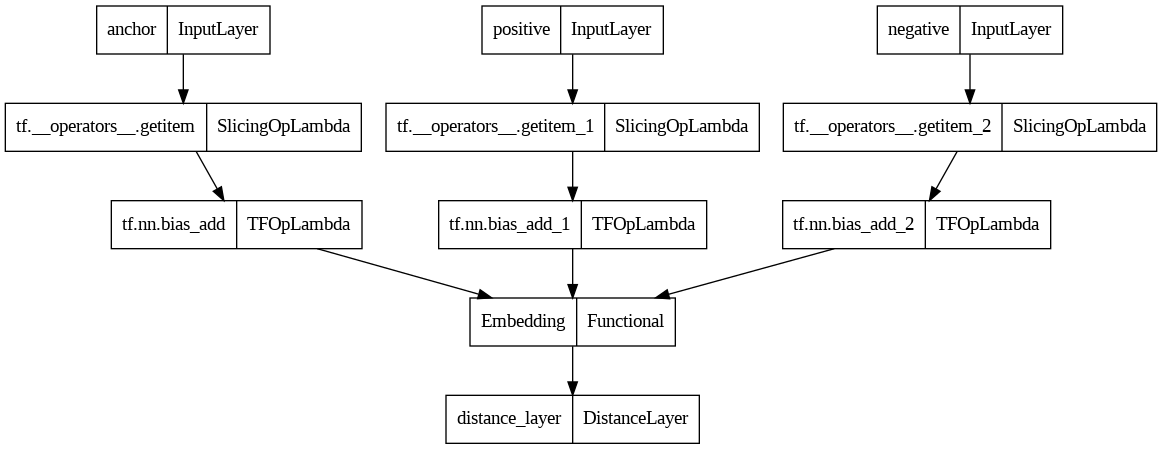

In [21]:
plot_model(siamese_network)

## Putting everything together

이제 Siamese 네트워크에서 생성된 3개의 임베딩을 사용하여 삼중항 손실을 계산할 수 있도록 사용자 지정 훈련 루프가 있는 모델을 구현해야 합니다.

훈련 과정의 손실을 추적하기 위해 'Mean' 메트릭 인스턴스를 생성해 보겠습니다.

In [22]:
class SiameseModel(Model):
    """사용자 정의 훈련 및 테스트 루프가 있는 샴 네트워크 모델.
    샴 네트워크에서 생성된 3개의 임베딩을 사용하여 삼중항 손실을 계산합니다.

    삼중항 손실은 다음과 같이 정의:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # 훈련 단계를 구현합니다. 데이터는 삼중항 손실을 계산하는 데 필요한 것입니다.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)
        # 그래디언트를 계산하고 최적화기에 적용합니다.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )
        # 손실을 업데이트하고 반환합니다.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        # 테스트 단계를 구현합니다. 데이터는 삼중항 손실을 계산하는 데 필요한 것입니다.
        loss = self._compute_loss(data)
        # 손실을 업데이트하고 반환합니다.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # 네트워크의 출력은 앵커와 포지티브, 앵커와 네거티브 사이의 거리를 포함하는 튜플입니다.
        ap_distance, an_distance = self.siamese_network(data)
        # 두 거리를 빼고 음수 값을 얻지 않도록 하여 삼중항 손실을 계산합니다.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        return loss

    @property
    def metrics(self):
        # 여기에 메트릭을 나열하면 `reset_states()`가 자동으로 호출됩니다.
        return [self.loss_tracker]

## Training

In [23]:
s = time.time()
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
history = siamese_model.fit(train_dataset, epochs=20, validation_data=val_dataset)

Epoch 1/20
151/151 [==============================] - ETA: 0s - loss: 0.4844

151/151 [==============================] - 96s 506ms/step - loss: 0.4844 - val_loss: 0.3801
Epoch 2/20
151/151 [==============================] - ETA: 0s - loss: 0.3919

151/151 [==============================] - 73s 482ms/step - loss: 0.3919 - val_loss: 0.3484
Epoch 3/20
151/151 [==============================] - ETA: 0s - loss: 0.3620

151/151 [==============================] - 70s 467ms/step - loss: 0.3620 - val_loss: 0.3417
Epoch 4/20
151/151 [==============================] - ETA: 0s - loss: 0.3495

151/151 [==============================] - 71s 472ms/step - loss: 0.3495 - val_loss: 0.3221
Epoch 5/20
151/151 [==============================] - ETA: 0s - loss: 0.3364

151/151 [==============================] - 71s 472ms/step - loss: 0.3364 - val_loss: 0.3559
Epoch 6/20
151/151 [==============================] - ETA: 0s - loss: 0.3326

151/151 [==============================] - 70s 466ms/step - loss: 0.3326 - val_loss: 0.3269
Epoch 7/20
151/151 [==============================] - ETA: 0s - loss: 0.3117

151/151 [==============================] - 71s 471ms/step - loss: 0.3117 - val_loss: 0.3065
Epoch 8/20
151/151 [==============================] - ETA: 0s - loss: 0.3085

151/151 [==============================] - 71s 473ms/step - loss: 0.3085 - val_loss: 0.3337
Epoch 9/20
151/151 [==============================] - ETA: 0s - loss: 0.2996

151/151 [==============================] - 72s 476ms/step - loss: 0.2996 - val_loss: 0.3101
Epoch 10/20
151/151 [==============================] - ETA: 0s - loss: 0.2901

151/151 [==============================] - 70s 467ms/step - loss: 0.2901 - val_loss: 0.3076
Epoch 11/20
151/151 [==============================] - ETA: 0s - loss: 0.2772

151/151 [==============================] - 71s 471ms/step - loss: 0.2772 - val_loss: 0.2922
Epoch 12/20
151/151 [==============================] - ETA: 0s - loss: 0.2790

151/151 [==============================] - 72s 474ms/step - loss: 0.2790 - val_loss: 0.3208
Epoch 13/20
151/151 [==============================] - ETA: 0s - loss: 0.2597

151/151 [==============================] - 70s 466ms/step - loss: 0.2597 - val_loss: 0.3133
Epoch 14/20
151/151 [==============================] - ETA: 0s - loss: 0.2655

151/151 [==============================] - 71s 473ms/step - loss: 0.2655 - val_loss: 0.2653
Epoch 15/20
151/151 [==============================] - ETA: 0s - loss: 0.2523

151/151 [==============================] - 71s 473ms/step - loss: 0.2523 - val_loss: 0.2891
Epoch 16/20
151/151 [==============================] - ETA: 0s - loss: 0.2493

151/151 [==============================] - 70s 465ms/step - loss: 0.2493 - val_loss: 0.2854
Epoch 17/20
151/151 [==============================] - ETA: 0s - loss: 0.2326

151/151 [==============================] - 71s 473ms/step - loss: 0.2326 - val_loss: 0.2857
Epoch 18/20
151/151 [==============================] - ETA: 0s - loss: 0.2309

151/151 [==============================] - 71s 471ms/step - loss: 0.2309 - val_loss: 0.2854
Epoch 19/20
151/151 [==============================] - ETA: 0s - loss: 0.2295

151/151 [==============================] - 71s 468ms/step - loss: 0.2295 - val_loss: 0.2885
Epoch 20/20
151/151 [==============================] - ETA: 0s - loss: 0.2126

151/151 [==============================] - 71s 468ms/step - loss: 0.2126 - val_loss: 0.2656


In [24]:
print("경과 시간 (분):", (time.time() - s)/60)

경과 시간 (분): 27.925573829809824


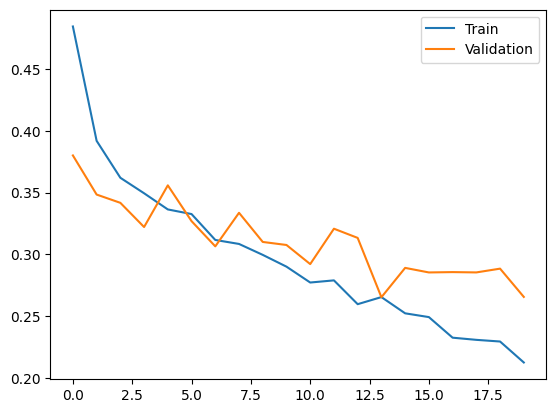

In [25]:
plt.plot(history.history['loss'], label="Train")
plt.plot(history.history['val_loss'], label="Validation")
plt.legend()

In [26]:
siamese_model.save_weights("siamese_weight.h5")

## 네트워크가 학습한 내용 검사

이제 네트워크가 유사한 이미지에 속하는지 여부에 따라 임베딩을 분리하는 방법을 학습한 것을 확인할 수 있습니다.

[코사인 유사도](https://en.wikipedia.org/wiki/Cosine_similarity)를 사용하여 임베딩 간의 유사도를 측정할 수 있습니다.

데이터 세트에서 샘플을 선택하여 각 이미지에 대해 생성된 임베딩 간의 유사성을 확인하겠습니다.

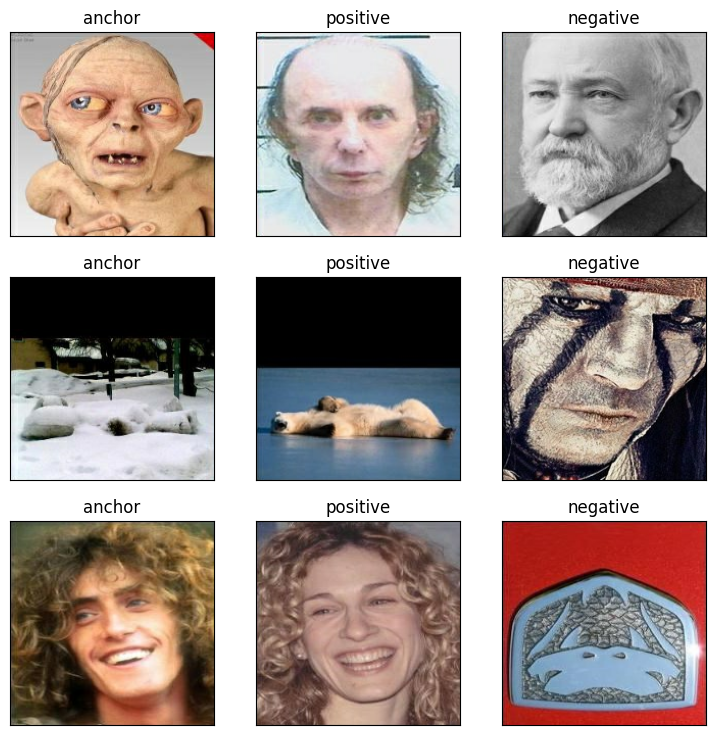

In [27]:
sample = next(iter(train_dataset))
visualize(*sample)

마지막으로 앵커와 포지티브 이미지 간의 코사인 유사도를 계산하고 앵커와 네거티브 이미지 간의 유사도와 비교할 수 있습니다.

앵커와 포지티브 이미지 사이의 유사도가 앵커와 네거티브 이미지 간의 유사도보다 클 것으로 예상 합니다.

In [28]:
# 세 가지 이미지: 기준 이미지(anchor), 긍정적 예시(positive), 부정적 예시(negative)
anchor, positive, negative = sample

# 사전 훈련된 ResNet 기반 이미지 임베딩 모델을 각 이미지에 적용합니다.
# 결과적으로 나오는 임베딩은 입력 이미지의 밀집 표현입니다.
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),  # anchor 이미지를 처리하고 임베딩을 생성합니다.
    embedding(resnet.preprocess_input(positive)),  # positive 이미지를 처리하고 임베딩을 생성합니다.
    embedding(resnet.preprocess_input(negative)),  # negative 이미지를 처리하고 임베딩을 생성합니다.
)

# 유클리디안 거리를 계산하는 함수를 정의합니다.
def euclidean_distance(a, b):
    return np.linalg.norm(a-b, axis=-1)

# 기준 이미지와 긍정적 예시 사이의 유클리디안 거리를 계산합니다.
positive_distance = euclidean_distance(anchor_embedding, positive_embedding)
print("Positive distance:", positive_distance)

# 기준 이미지와 부정적 예시 사이의 유클리디안 거리를 계산합니다.
negative_distance = euclidean_distance(anchor_embedding, negative_embedding)
print("Negative distance:", negative_distance)


Positive distance: [0.7026962  0.8720669  0.6695967  0.7085859  1.0591594  0.88133115
 0.9459273  0.8924203  1.0391383  0.7917858  1.0806738  0.7689188
 1.2084123  1.0655198  1.1275752  0.6909935  0.8247835  0.8546759
 1.0024794  0.6717296  0.7626141  0.5319731  0.79521114 1.0118505
 0.8658525  0.9539678  1.0327092  1.0307578  0.81696504 0.7717169
 0.92172647 1.1658691 ]
Negative distance: [1.0346868  1.3117807  1.2336254  1.5977116  1.77103    0.97881234
 1.1346964  1.9360814  2.1531827  1.4112554  1.0119222  1.3764888
 1.418502   0.8536283  1.1043887  1.0954882  1.2132307  1.5195541
 1.0033109  1.7679391  0.8405102  0.9463087  1.058528   0.85242194
 1.021678   1.4137218  1.2375524  1.3882623  1.6520534  1.3006881
 1.1665654  1.5106561 ]


In [29]:
np.mean(positive_distance)

0.8912401

In [30]:
np.mean(negative_distance)

1.2911332

전체 Train set 에 대한 유사도 계산

In [31]:
# 긍정적 예시와 부정적 예시 간의 유사도를 저장할 리스트를 초기화합니다.
positive_similarities = []
negative_similarities = []

# 훈련 데이터셋의 각 이미지 샘플에 대해
for anchor, positive, negative in train_dataset:
    # 각 이미지를 ResNet 기반 이미지 임베딩 모델에 적용하여
    # 이미지의 밀집 표현인 임베딩을 생성합니다.
    anchor_embedding, positive_embedding, negative_embedding = (
        embedding(resnet.preprocess_input(anchor)),  # 기준 이미지를 처리하고 임베딩을 생성합니다.
        embedding(resnet.preprocess_input(positive)),  # 긍정적 예시 이미지를 처리하고 임베딩을 생성합니다.
        embedding(resnet.preprocess_input(negative)),  # 부정적 예시 이미지를 처리하고 임베딩을 생성합니다.
    )

    # 기준 이미지와 긍정적 예시 사이의 코사인 유사도를 계산합니다.
    positive_distance = euclidean_distance(anchor_embedding, positive_embedding)
    # 계산한 유사도를 리스트에 추가합니다.
    positive_similarities.append(np.mean(positive_distance))

    # 기준 이미지와 부정적 예시 사이의 코사인 유사도를 계산합니다.
    negative_distance = euclidean_distance(anchor_embedding, negative_embedding)
    # 계산한 유사도를 리스트에 추가합니다.
    negative_similarities.append(np.mean(negative_distance))

positive similarity의 최대값 : 0.9930222


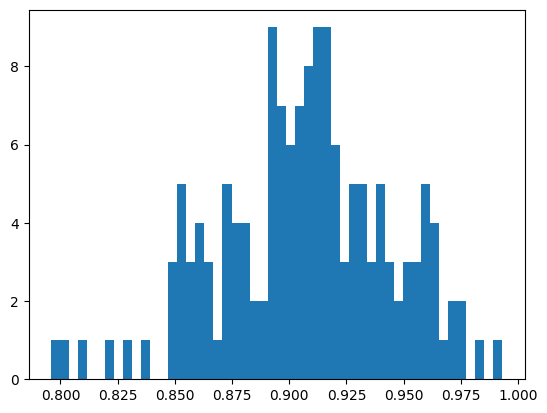

In [32]:
plt.hist(positive_similarities, bins=50);
print("positive similarity의 최대값 :", max(positive_similarities))

negative similarity의 최소값 : 1.359843


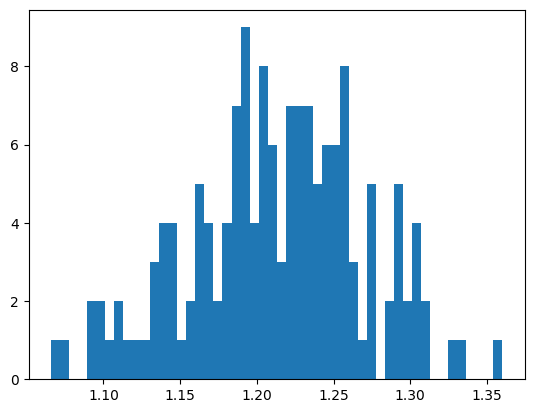

In [33]:
plt.hist(negative_similarities, bins=50);
print("negative similarity의 최소값 :", max(negative_similarities))

In [34]:
threshold = (np.mean(positive_similarities) + np.mean(negative_similarities)) / 2
threshold

1.0596083402633667

 위 plot 에서 threshold를 정하여 이진 분류 모델 작성

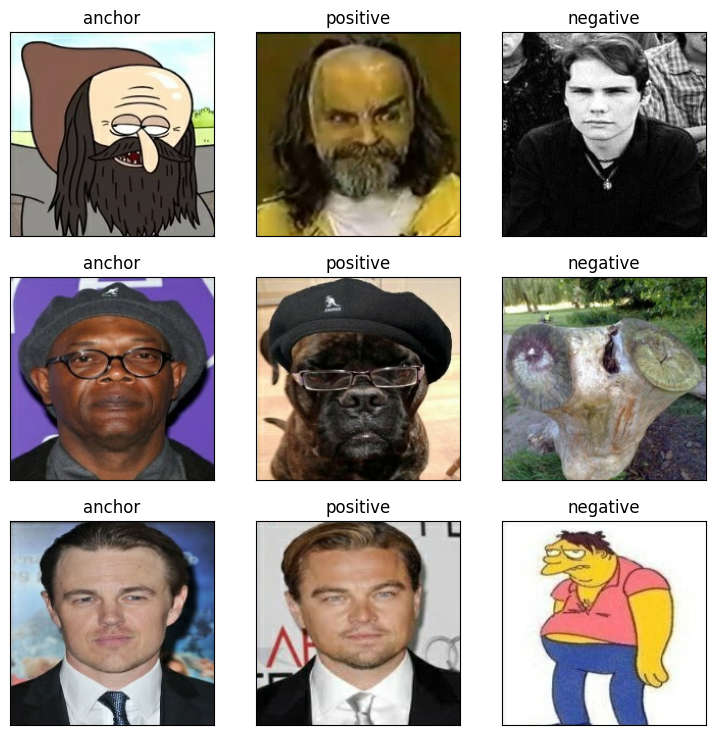

In [35]:
sample = next(iter(val_dataset))
visualize(*sample)

이미지 데이터가 배열로 제공될 때, 배열에서 첫 번째 이미지만 사용하여 각각의 이미지에 대한 임베딩을 생성합니다. resnet.preprocess_input() 함수는 ResNet 모델에 입력으로 제공될 데이터를 적절히 전처리하며, embedding() 함수는 전처리된 이미지를 이미지 임베딩으로 변환합니다. [0:1]의 사용은 Python의 슬라이싱 기법으로, 첫 번째 요소만 선택하되 결과를 배열 형태로 유지하기 위한 것입니다.

In [36]:
# 세 가지 이미지 샘플: 기준 이미지(anchor), 긍정적 예시(positive), 부정적 예시(negative)
anchor, positive, negative = sample

# ResNet 기반의 이미지 임베딩 모델을 각 이미지에 적용합니다. 이미지의 배열에서 첫 번째 요소만 사용합니다.
# 결과적으로 나오는 임베딩은 입력 이미지의 밀집 표현입니다.
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor[10:11])),  # anchor 이미지 배열의 첫 번째 요소를 처리하고 임베딩을 생성합니다.
    embedding(resnet.preprocess_input(positive[10:11])),  # positive 이미지 배열의 첫 번째 요소를 처리하고 임베딩을 생성합니다.
    embedding(resnet.preprocess_input(negative[10:11])),  # negative 이미지 배열의 첫 번째 요소를 처리하고 임베딩을 생성합니다.
)

In [37]:
similarity_score = euclidean_distance(anchor_embedding, positive_embedding)
print("임계값 :", threshold, similarity_score)
if  similarity_score < threshold:
    print("유사도 : {similarity_score} ==> same person")
else:
    print("유사도 : {similarity_score} ==> different person")

임계값 : 1.0596083402633667 [0.6839838]
유사도 : {similarity_score} ==> same person


In [38]:
similarity_score = euclidean_distance(anchor_embedding, negative_embedding)
print("임계값 :", threshold, similarity_score)
if  similarity_score < threshold:
    print("유사도 : {similarity_score} ==> same person")
else:
    print("유사도 : {similarity_score} ==> different person")

임계값 : 1.0596083402633667 [1.41058]
유사도 : {similarity_score} ==> different person


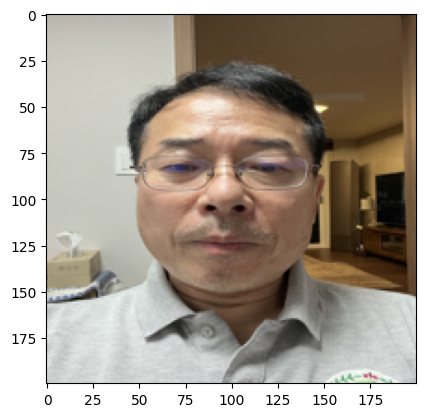

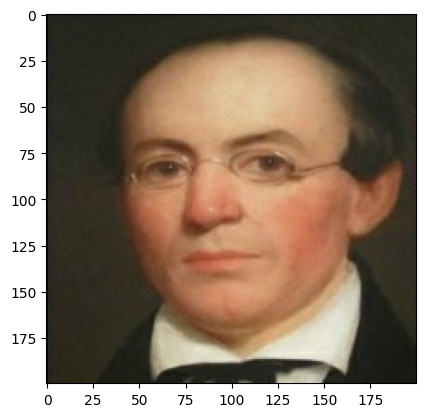

In [40]:
img = Image.open('oyjselfi.jpg').resize((200, 200))
plt.imshow(img)
plt.show()

img = np.expand_dims(np.array(img), axis=0)
anchor_embedding = embedding(resnet.preprocess_input(img))

# img1 = Image.open('PHOTO오영제.jpg').resize((200, 200))
img1 = anchor[10]
plt.imshow(img1)
plt.show()

img1 = np.expand_dims(np.array(img1), axis=0)
compare_embedding = embedding(resnet.preprocess_input(anchor[10:11]))

In [41]:
similarity_score = euclidean_distance(anchor_embedding, compare_embedding)
print("임계값 :", threshold, similarity_score)
if  similarity_score < threshold:
    print("유사도 : {similarity_score} ==> same person")
else:
    print("유사도 : {similarity_score} ==> different person")

임계값 : 1.0596083402633667 [7.6871533]
유사도 : {similarity_score} ==> different person
